# Assignment 1: CRF sequence tagging for Movie Queries

This coursework involves optimizing the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 

This assignment involves reading in, pre-processing, training and developing your tagger on the training data from *trivia10k13train.bio.txt*, and finally testing your tagger on the data *trivia10k13test.bio.txt*, attempting to get the best performing tagger across the different labels in your development process. Parts of these steps have been done for you already. You are going to optimize the performance of the tagger by improving its feature extraction function on the word sequences, incorporating POS tagging first, then the final exercise is to optimize the performance by all legal means neccessary (except looking at the test data). Run and follow the code below and then attempt the questions.

**NOTEBOOK/CODE SUBMISSION: PLEASE SUBMIT IN NOTEBOOK FORM IF YOU CAN RATHER THAN IN A PYTHON FILE, MAKING YOUR CODE ADDITIONS TO THIS TEMPLATE FILE. SUBMISSION MUST BE IN PYTHON 3.7+ AND YOU MUST HAVE RUN THE CODE RUNNING FROM TOP TO BOTTOM BEFORE SUBMISSION.**

**WRITTEN REPORT SUBMISSION: YOU MUST INCLUDE A 2-PAGE MAX LENGTH REPORT SUMMARIZING HOW YOU WENT ABOUT ACHIEVING EACH QUESTION, TO BE SUBMITTED WITH YOUR CODE. PLEASE WRITE SUCCINCTLY AND CLEARLY, IN THE STYLE OF A SCIENTIFIC NLP CONFERENCE PAPER. AUTOMATIC PLAGIARISM DETECTION WILL BE RUN ON THESE FILES.**

In [88]:
# You may need to run this first- uncomment if so
!pip install python-crfsuite

In [89]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [90]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [91]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [92]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [93]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


In [94]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [95]:
training_data = [preProcess(example) for example in raw_training_data]

In [96]:
# check the effect of pre-processing
print(training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [97]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [98]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [99]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [100]:
# an example from the corpus
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
print_tags(example)

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [101]:
# a novel, unseen example we've just made up
print_tags("batman is the main character in batman begins")

batman      O
is          O
the         O
main        O
character   O
in          O
batman      B-Character_Name
begins      I-Character_Name


In [102]:
# another example
print_tags("the sound of music")

the         O
sound       O
of          O
music       O


In [103]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1953 instances
39035 words


In [104]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [105]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.86      0.88      0.87      1274
         B-Award       0.72      0.62      0.67        66
B-Character_Name       0.81      0.24      0.37       283
      B-Director       0.84      0.72      0.78       425
         B-Genre       0.83      0.76      0.79       789
       B-Opinion       0.49      0.30      0.37       195
        B-Origin       0.52      0.38      0.44       190
          B-Plot       0.49      0.47      0.48      1577
         B-Quote       0.75      0.26      0.38        47
  B-Relationship       0.80      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.94      0.97      0.96       661
         I-Actor       0.86      0.89      0.87      1553
         I-Award       0.74      0.69      0.72       147
I-Character_Name       0.84      0.29      0.43       227
      I-Director       0.89      0.74      0.81       411
         I-Ge

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [106]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

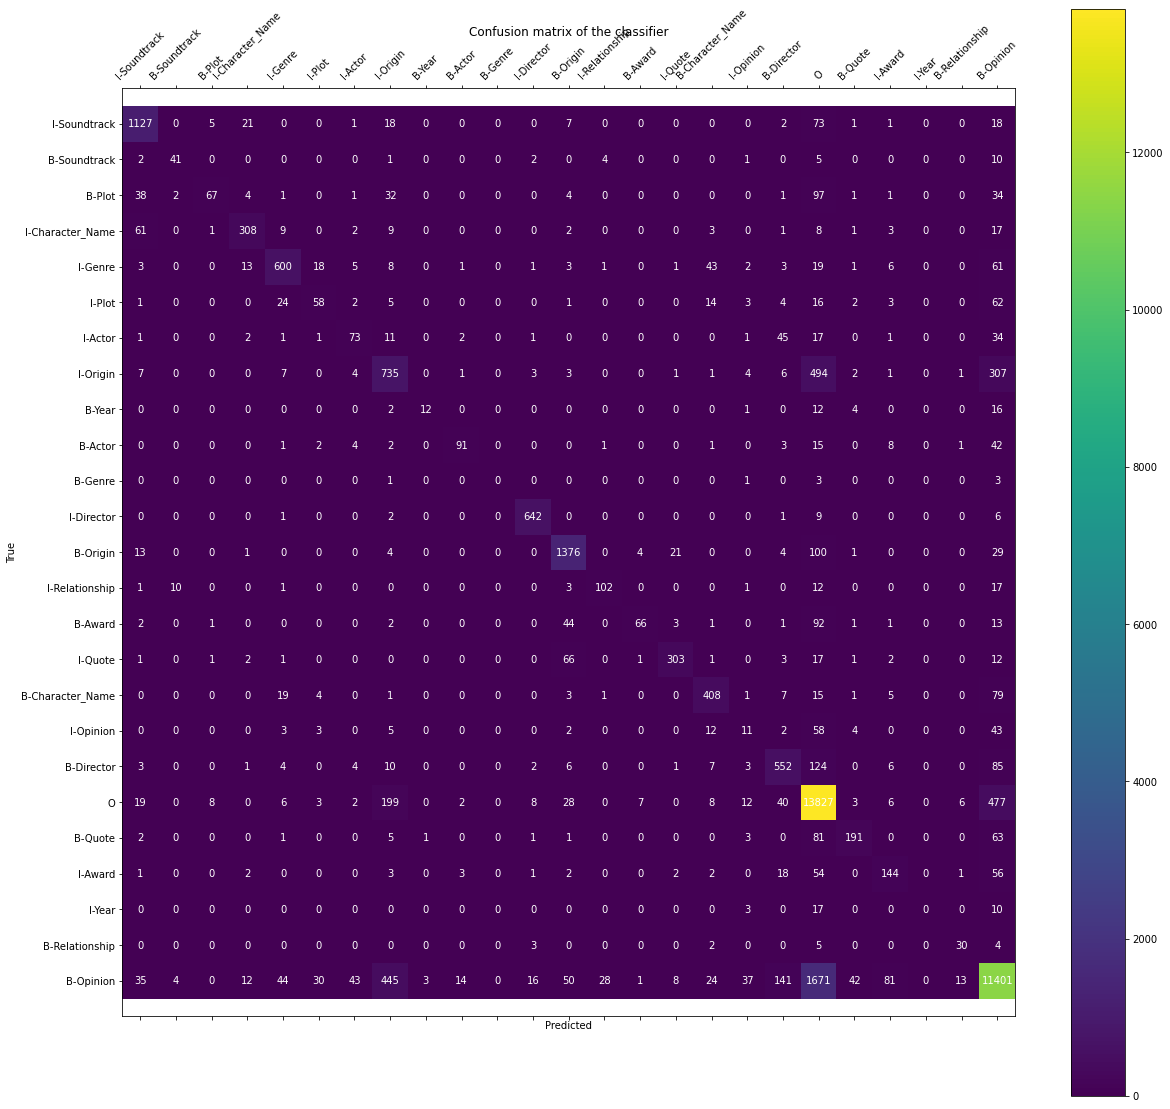

In [107]:
confusion_matrix_heatmap(y_test, preds)

In [108]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [109]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [110]:
print_transition_weights(ct._tagger.info().transitions.items())

8.724577 B-Actor  -> I-Actor
8.339819 B-Plot   -> I-Plot
8.056264 B-Director -> I-Director
7.844567 B-Origin -> I-Origin
7.724763 I-Plot   -> I-Plot
7.553570 I-Quote  -> I-Quote
7.397641 B-Character_Name -> I-Character_Name
7.342680 I-Origin -> I-Origin
7.263004 B-Relationship -> I-Relationship
7.140895 B-Quote  -> I-Quote
7.013351 I-Relationship -> I-Relationship
6.867795 I-Soundtrack -> I-Soundtrack
6.788047 I-Opinion -> I-Opinion
6.732937 B-Genre  -> I-Genre
6.693016 B-Soundtrack -> I-Soundtrack
6.578020 B-Award  -> I-Award
6.435503 B-Opinion -> I-Opinion
6.422268 I-Award  -> I-Award
6.355522 I-Genre  -> I-Genre
6.344544 I-Actor  -> I-Actor
6.220084 I-Character_Name -> I-Character_Name
5.427243 I-Director -> I-Director
4.815258 I-Year   -> I-Year
4.083843 B-Year   -> I-Year
3.776230 B-Character_Name -> B-Plot
3.564706 O        -> O
3.561946 I-Character_Name -> B-Plot
3.277159 O        -> B-Plot
3.197475 B-Plot   -> B-Character_Name
3.085634 B-Opinion -> B-Genre
3.028571 O        -> 

In [111]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [112]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

Streaming output truncated to the last 5000 lines.
0.013258 I-Plot   WORD_polluted
0.013211 I-Plot   WORD_expedition
0.013197 B-Character_Name SUF_red
0.013182 B-Plot   SUF_rns
0.013164 I-Plot   SUF_fee
0.013164 I-Plot   WORD_coffee
0.013141 I-Plot   SUF_edo
0.013129 I-Plot   WORD_behalf
0.013113 B-Plot   WORD_documents
0.013078 I-Plot   WORD_farmboy
0.013059 I-Actor  SUF_fia
0.013046 I-Plot   WORD_materials
0.013036 I-Plot   WORD_naked
0.013034 I-Plot   WORD_attic
0.013004 I-Plot   WORD_gravely
0.012983 I-Award  SUF_ous
0.012973 I-Plot   WORD_idealism
0.012969 B-Quote  SUF_ed
0.012968 I-Plot   WORD_tanked
0.012964 I-Plot   WORD_expense
0.012921 I-Plot   SUF_iya
0.012921 I-Plot   WORD_wadiya
0.012919 I-Plot   WORD_agency
0.012881 I-Plot   SUF_urt
0.012880 I-Plot   WORD_gig
0.012871 I-Plot   WORD_orchestrated
0.012843 I-Plot   WORD_suspension
0.012835 B-Character_Name WORD_sugar
0.012830 I-Plot   WORD_fend
0.012828 I-Plot   WORD_recounts
0.012805 I-Plot   WORD_solely
0.012792 I-Plot   W

# 1. Question 1- Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


## Step 1:-

---
<h4>Splittng the training datset into two parts:- </h4>

<h4> <em>
1) First 80% for training

2) Remaining 20% for testing
</em> </h4>

<h4><em>Using the train_test_split method from sklearn and setting the parameters "shuffle = False" and "stratify = None" to prevent random splitting of the data</em></h4>




In [113]:
import numpy as np

# importing the train_test_split function from sklearn which will be used to split the data set into two lists of training and testing
from sklearn.model_selection import train_test_split
X = training_data

# two lists X_train and X_test have been created where X_train is set to 80% of the total data and the X_test is set to 20% of the total data
X_train_1, X_test_1 = train_test_split(X, train_size=0.8, random_state = None, shuffle = False, stratify = None)

## Step 2:-

<h4><em>Training the CRF Tagger on the 80% split train data and storing our model into our runtime</em></h4>



In [114]:
# train the CRF BIO-tag tagger again with thr 80% train data
TAGGER_PATH = "crf_nlu.tagger_new"  # saving the new tagger model to this path
ct = CRFTagger(feature_func=get_features)  # initializing tagger with get_features function

print("training tagger...")
ct.train(X_train_1, TAGGER_PATH)
print("done")

training tagger...
done


## Step 3:-

<h4><em>Making predictions on the 20% split test data and storing test data labels and predicted data labels into two different lists </em></h4>



In [115]:
# making lists preds_1 and y_test_1 for storing the true and predicted test labels
print("testing the tagger on the test data...")
preds_1 = []
y_test_1 = []
for sent in X_test_1:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_1.extend(sent_preds)
    y_test_1.extend(sent_true)
print("done")

testing the tagger on the test data...
done


## Step 4:-

<h4><em>Generating the classification report (using the test data labels and predicted data labels) which contains different model metrics such as the accuracy, precisiom, recall and f1 score. Further printing a confusion matrix using the same labels in order to display true/flase classification of different classes</em></h4>



In [116]:
# Generating the classfication report to evaluate the accuracy of the model
cr = classification_report(y_test_1, preds_1, output_dict= True)
print(classification_report(y_test_1, preds_1))
print(precision_recall_fscore_support(y_test_1, preds_1, average='macro'))  # print out accurate macro average 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

                  precision    recall  f1-score   support

         B-Actor       0.87      0.87      0.87      1231
         B-Award       0.76      0.60      0.67        75
B-Character_Name       0.65      0.13      0.22       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.47      0.23      0.30       160
        B-Origin       0.58      0.44      0.50       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.82      0.41      0.55       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.89      0.84      0.87      1731
         I-Award       0.79      0.81      0.80       202
I-Character_Name       0.61      0.12      0.20       165
      I-Director       0.86      0.66      0.75       456
         I-Ge

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [117]:
# creating a function to print the confusion matrix

def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

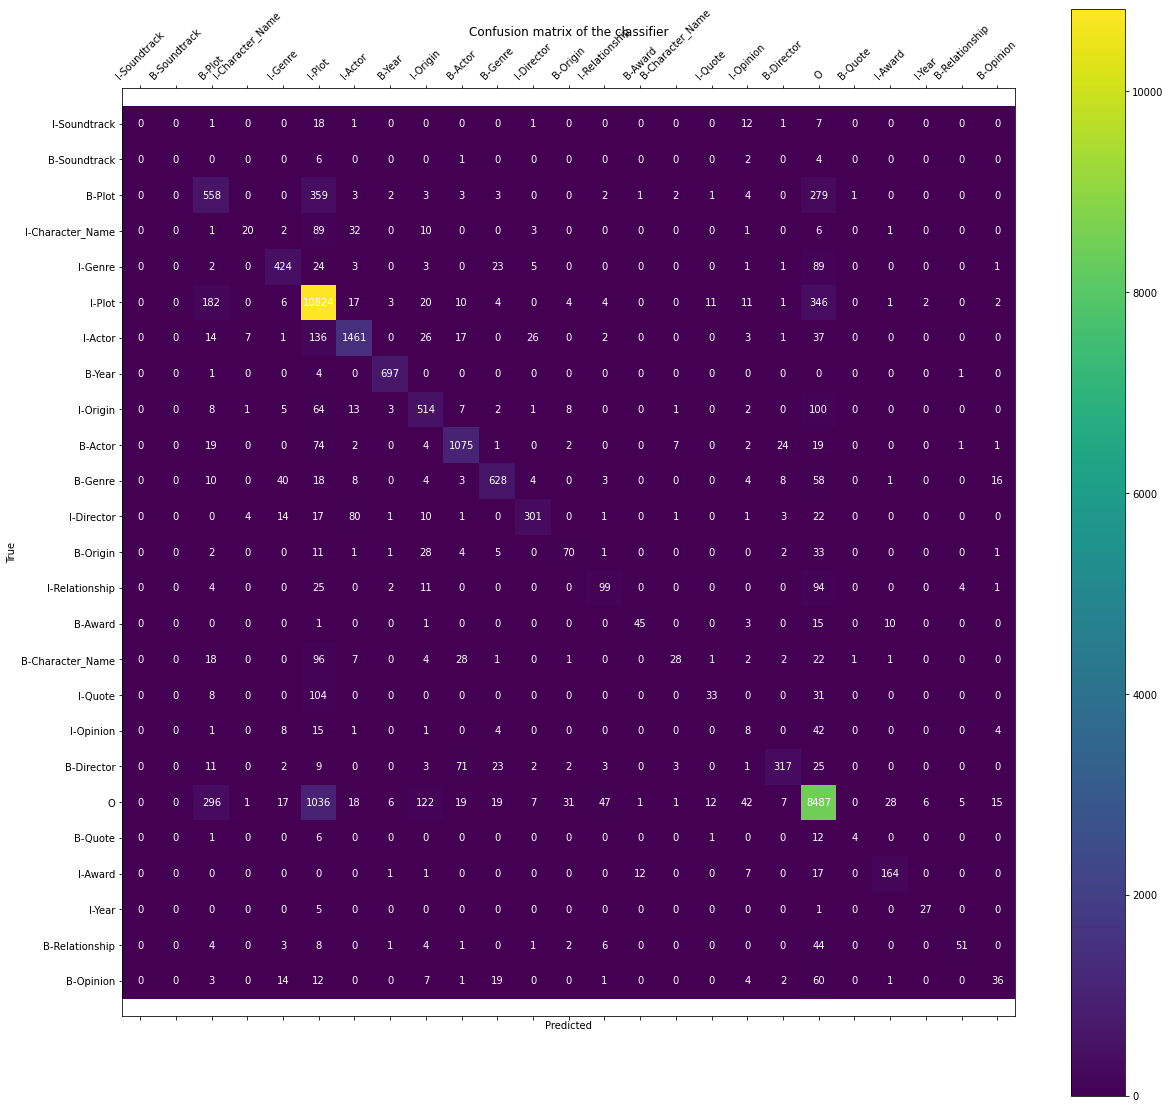

In [118]:
# creating a confusion matrix for the y_test_1 and preds_1
confusion_matrix_heatmap(y_test_1, preds_1)

## Conclusion
<h4><em> We have split our data into two parts, the first 80% of the data as the train set and the rest 20% as the test set. Thereafter we trained our model (CRF Tagger) on the split data (80%) and made predictions on our 20% test data. To get an overview of the performance of our model we have printed the classification report which shows the accuracy, precision, recall, f1-score and macro/weighted averages for individual classes. Finally to visualise the true and the false prediction we have printed a confusion matrix. </em></h4>

# 2. Question 2- Error analysis 1: False positives (5 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


## Step 1:-

<h4><em>Using the classification matrix from the previous problem as a dataframe, sorting the precision values from low to high in order to get the 5 classes with the lowest precision among all </em></h4>

In [119]:
# creating a dataframe of the classification report in order to further sort it for extracting lowest 5 precision values.
import io
import pandas as pd
df = pd.DataFrame(cr).transpose()

In [120]:
display(df)

,precision,recall,f1-score,support
B-Actor,0.866237,0.873274,0.869741,1231.000000
B-Award,0.762712,0.600000,0.671642,75.000000
B-Character_Name,0.651163,0.132075,0.219608,212.000000
B-Director,0.859079,0.671610,0.753864,472.000000
B-Genre,0.857923,0.780124,0.817176,805.000000
B-Opinion,0.467532,0.225000,0.303797,160.000000
B-Origin,0.583333,0.440252,0.501792,159.000000
B-Plot,0.487762,0.457002,0.471882,1221.000000
B-Quote,0.666667,0.166667,0.266667,24.000000
B-Relationship,0.822581,0.408000,0.545455,125.000000


In [121]:
# sorting the valules by column precision
prec_val = df.sort_values(by= 'precision')

In [122]:
lowest_five_values = prec_val.head(5)

In [123]:
lowest_five_values

,precision,recall,f1-score,support
I-Soundtrack,0.000000,0.000000,0.000000,41.0
B-Soundtrack,0.000000,0.000000,0.000000,13.0
I-Opinion,0.072727,0.095238,0.082474,84.0
B-Opinion,0.467532,0.225000,0.303797,160.0
B-Plot,0.487762,0.457002,0.471882,1221.0


In [124]:
# storing the labels into a list
five_labels = []
for i in range(5):
  five_labels.append(lowest_five_values.index[i])
five_labels

['I-Soundtrack', 'B-Soundtrack', 'I-Opinion', 'B-Opinion', 'B-Plot']

## Step 2:-

<h4><em>In the second step I found out the false positive words from all the sentences by comapring the predicted labels with the true labels and checking if those predicted labels are in there in the 5 classes with the lowest precision i.e ['I-Soundtrack', 'B-Soundtrack', 'I-Opinion', 'B-Opinion', 'B-Plot']. Further appending the following data in a dataframe for a better visualization:-    </em></h4>

*   Predicted Label
*   True Label
*   The false positive word
*   The index of that word in that particular sentence
*   The sentence which has false positive/false positives







In [125]:
import pandas as pd
print("Selecting all the sentences which have false positives in the five_labels with lowest precision.......")
result = []
result_df = pd.DataFrame(result)

#running two for loops, one for the sentence and another nested for loop for working on the words. 
for sent in X_test_1:
    #predicted labels from the sentence
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    #true labels from the sentence
    sent_true = [s[1] for s in sent]
    #extracting words from the sentence
    sent_words = [s[0] for s in sent]
    #checking the condition of false positives for the 5 classes
    for i in range(len(sent_true)):
      if(sent_preds[i] != sent_true[i] and sent_preds[i] in five_labels):
        result_df=result_df.append({'True Label':sent_true[i],'Predicted Label':sent_preds[i],'Word':sent_words[i],'Index': f'Word {i} of this Sentence','Sentence':tuple(sent)},ignore_index=True)
        
print("Found all the sentences with False positives and extracted their true and false labels along with the words...")

Selecting all the sentences which have false positives in the five_labels with lowest precision.......
Found all the sentences with False positives and extracted their true and false labels along with the words...


In [126]:
#rearrangin the result for a better readability
arranged_result = result_df.reindex(columns=['Predicted Label', 'True Label', 'Word','Index', 'Sentence'])
arranged_result

,Predicted Label,True Label,Word,Index,Sentence
0,B-Plot,I-Plot,a,Word 1 of this Sentence,"((on, B-Plot), (a, I-Plot), (vacation, I-Plot)..."
1,B-Plot,O,beautiful,Word 8 of this Sentence,"((one, O), (of, O), (the, O), (first, O), (dis..."
2,B-Plot,I-Plot,roistering,Word 19 of this Sentence,"((orson, B-Director), (welles, I-Director), (d..."
3,B-Plot,O,psychological,Word 2 of this Sentence,"((orson, B-Actor), (wells, I-Actor), (psycholo..."
4,B-Plot,B-Actor,thomas,Word 3 of this Sentence,"((paul, B-Actor), (giamatti, I-Actor), (and, O..."
...,...,...,...,...,...
724,B-Plot,I-Plot,a,Word 11 of this Sentence,"((william, B-Director), (brent, I-Director), (..."
725,B-Plot,B-Actor,a,Word 3 of this Sentence,"((winona, B-Actor), (ryder, I-Actor), (is, O),..."
726,B-Plot,O,you,Word 0 of this Sentence,"((you, O), (are, O), (living, B-Plot), (in, I-..."
727,B-Plot,O,you,Word 0 of this Sentence,"((you, O), (are, O), (told, O), (that, O), (wh..."


## Step 3:-

<h4><em> The above table contains 729 rows which means there are a total 729 different words which are falsely classified. These observations may have a single sentence printed multiple times for exampple: if there are 3 false positives in a sentence, that sentence will be printed 3 times.
I went on to find out the unique number of sentences which would have at-least one false positive in it. I achieved this using the drop_duplicataes method of pandas dataframe.
The total number of unique sentences which have at least one false positive are 619.
</em><h4>

In [127]:
print("Removing all the duplicate sentences which will be genertaed when there are false positives from the same sentence to get total number of sentences containing false positives.....")
result_df_u = result_df.drop_duplicates(subset='Sentence')
arranged_result_u = result_df_u.reindex(columns=['Predicted Label', 'True Label', 'Word','Index', 'Sentence'])
display(arranged_result_u)
print("Total number of unique sentences are",result_df_u.shape[0])

Removing all the duplicate sentences which will be genertaed when there are false positives from the same sentence to get total number of sentences containing false positives.....


,Predicted Label,True Label,Word,Index,Sentence
0,B-Plot,I-Plot,a,Word 1 of this Sentence,"((on, B-Plot), (a, I-Plot), (vacation, I-Plot)..."
1,B-Plot,O,beautiful,Word 8 of this Sentence,"((one, O), (of, O), (the, O), (first, O), (dis..."
2,B-Plot,I-Plot,roistering,Word 19 of this Sentence,"((orson, B-Director), (welles, I-Director), (d..."
3,B-Plot,O,psychological,Word 2 of this Sentence,"((orson, B-Actor), (wells, I-Actor), (psycholo..."
4,B-Plot,B-Actor,thomas,Word 3 of this Sentence,"((paul, B-Actor), (giamatti, I-Actor), (and, O..."
...,...,...,...,...,...
724,B-Plot,I-Plot,a,Word 11 of this Sentence,"((william, B-Director), (brent, I-Director), (..."
725,B-Plot,B-Actor,a,Word 3 of this Sentence,"((winona, B-Actor), (ryder, I-Actor), (is, O),..."
726,B-Plot,O,you,Word 0 of this Sentence,"((you, O), (are, O), (living, B-Plot), (in, I-..."
727,B-Plot,O,you,Word 0 of this Sentence,"((you, O), (are, O), (told, O), (that, O), (wh..."


Total number of unique sentences are 619


In [128]:
#printing all the sentences containing false positives
temp = []
for i in range(len(result_df_u['Sentence'])):
  try:
    newtemp = ''
    for j in range(len(result_df_u['Sentence'][i])):
      newtemp += ' '+(result_df_u['Sentence'][i][j][0])
    temp.append(newtemp)
  except KeyError:
    continue

In [129]:
for i in range(len(temp)):
  print(temp[i])

 on a vacation in paris one of three travelers is mistaken for a british heiress
 one of the first disney animated films with beautiful images few lines and a lot of music
 orson welles directed and starred in this 1965 movie about the career of shakespeare s sir john falstaff as roistering companion to young prince hal
 orson wells psychological profile of an eccentric billionaire has been voted the greatest movie of all time by some
 paul giamatti and thomas haden church are two men reaching middle age with not much to show but disappointment in this 2004 comedy romance movie
 paul newman starred in this 1977 hockey movie about the struggles of a minor league team
 perseus mortal son of zeus battles the minions of the underworld to stop them from conquering the earth and the heavens in this 2010 action adventure fantasy
 peter hedges directed this charming fantasy based on the story by ahmet zappa about a boy who joins a family by rather unusual means
 peter jackson directed this sma

## Conclusion
<h4><em> We performed error analysis for false positives where we found out that there were a total of 729 false positives in our data. The total number of sentences which had false positives(atleast 1 in each sentenc) were 619. In order to reduce the number of false positives we need to add extra features to our model, for example:- the pos tags, next/previous words, extra prefix and suffix etc. This is done to increase the overall macro average (f1 score) of our model which also happens to be the harmonic mean of precision and recall. If we increase the f1 score, the precision will also increase which will inturn decrease the false positives. "(Precision is given by (true_positives)÷(true_positives+false_positives))" This has been achieved in the question number 4 and 5.</em></h4>

# 3. Question 3- Error analysis 2: False negatives (5 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


## Step 1:-

<h4><em>Using the same classification matrix from the previous problem as a dataframe, sorting the recall values from low to high in order to get the 5 classes with the lowest recall among all </em></h4>

In [130]:
import io
import pandas as pd

#creating a dataframe out of the classification matrix
df1 = pd.DataFrame(cr).transpose()

In [131]:
# extracting the lowest five recall values
rec_val = df.sort_values(by= 'recall')
lowest_five = rec_val.head(5)
lowest_five

,precision,recall,f1-score,support
B-Soundtrack,0.000000,0.000000,0.000000,13.0
I-Soundtrack,0.000000,0.000000,0.000000,41.0
I-Opinion,0.072727,0.095238,0.082474,84.0
I-Character_Name,0.606061,0.121212,0.202020,165.0
B-Character_Name,0.651163,0.132075,0.219608,212.0


In [132]:
#creating a list of the 5 labels
five_labels_1 = []
for i in range(5):
  five_labels_1.append(lowest_five.index[i])
five_labels_1

['B-Soundtrack',
 'I-Soundtrack',
 'I-Opinion',
 'I-Character_Name',
 'B-Character_Name']

## Step 2:-

<h4><em>In the second step I found out the false negative words from all the sentences by comapring the predicted labels with the true labels and checking if the true labels are there in the 5 classes with the lowest precision i.e ['I-Soundtrack', 'B-Soundtrack', 'I-Opinion', 'I-Character_Name', 'B-Character_Name']. Further appending the following data in a dataframe for a better visualization:-    </em></h4>

*   Predicted Label
*   True Label
*   The false positive word
*   The index of that word in that particular sentence
*   The sentence which has false positive/false positives







In [133]:
import pandas as pd
print("Selecting all the sentences which have False Negatives in the five_labels with lowest precision.......")
result_1 = []
result_df_1 = pd.DataFrame(result_1)
for sentence in X_test_1:
    #predicted labels
    preds = [a[1] for a in ct.tag([s[0] for s in sentence])]
    #true labels
    true = [s[1] for s in sentence]
    #words
    words = [s[0] for s in sentence]
    #condition for checking false negatives
    for i in range(len(true)):
      if(preds[i] != true[i] and true[i] in five_labels_1):
        #print(sent_true[i],'     is misclassified into    ',sent_preds[i],'Word:  ',sent_words[i])
        result_df_1=result_df_1.append({'True Label':true[i],'Predicted Label':preds[i],'Word':words[i],'Index': f'Word {i} of this sentence','Sentence':tuple(sentence)},ignore_index=True)
print("Found all the sentences with False Negatives and extracted their true and false labels along with the words...")

Selecting all the sentences which have False Negatives in the five_labels with lowest precision.......
Found all the sentences with False Negatives and extracted their true and false labels along with the words...


In [134]:
result_df_1.shape

(459, 5)

In [135]:
arranged_result_1 = result_df_1.reindex(columns=['Predicted Label', 'True Label', 'Word','Index','Sentence'])
display(arranged_result_1)

,Predicted Label,True Label,Word,Index,Sentence
0,O,I-Opinion,memorable,Word 4 of this sentence,"((one, O), (of, O), (the, O), (most, B-Opinion..."
1,O,I-Opinion,scenes,Word 5 of this sentence,"((one, O), (of, O), (the, O), (most, B-Opinion..."
2,I-Plot,I-Opinion,movie,Word 13 of this sentence,"((orson, B-Actor), (wells, I-Actor), (psycholo..."
3,I-Plot,I-Opinion,of,Word 14 of this sentence,"((orson, B-Actor), (wells, I-Actor), (psycholo..."
4,I-Plot,I-Opinion,all,Word 15 of this sentence,"((orson, B-Actor), (wells, I-Actor), (psycholo..."
...,...,...,...,...,...
454,I-Plot,B-Character_Name,dieter,Word 13 of this sentence,"((will, B-Actor), (forte, I-Actor), (plays, O)..."
455,I-Plot,I-Character_Name,von,Word 14 of this sentence,"((will, B-Actor), (forte, I-Actor), (plays, O)..."
456,I-Plot,I-Character_Name,cunth,Word 15 of this sentence,"((will, B-Actor), (forte, I-Actor), (plays, O)..."
457,I-Plot,B-Character_Name,allan,Word 2 of this sentence,"((young, B-Plot), (traveler, I-Plot), (allan, ..."


## Step 3:-

<h4><em> The above table contains 459 rows which means there are a total 459 different words which are false negatives. These observations may have a single sentence printed multiple times for exampple: if there are 3 false negatives in a sentence, that sentence will be printed 3 times.
I went on to find out the unique number of sentences which would have at-least one false negative in it. I achieved this using the drop_duplicataes method of pandas dataframe.
The total number of unique sentences which have at least one false negative are 201.
</em><h4>

In [136]:
print("Removing all the duplicate sentences which will be genertaed when there are false negatives from the same sentence.....")
result_df_1_u = result_df_1.drop_duplicates(subset='Sentence')
display(result_df_1_u)
print('The total number of sentences having atleast 1 False Negative are',result_df_1_u.shape[0])

Removing all the duplicate sentences which will be genertaed when there are false negatives from the same sentence.....


,Index,Predicted Label,Sentence,True Label,Word
0,Word 4 of this sentence,O,"((one, O), (of, O), (the, O), (most, B-Opinion...",I-Opinion,memorable
2,Word 13 of this sentence,I-Plot,"((orson, B-Actor), (wells, I-Actor), (psycholo...",I-Opinion,movie
6,Word 4 of this sentence,B-Actor,"((paul, B-Actor), (newman, I-Actor), (stars, O...",B-Character_Name,rocky
8,Word 0 of this sentence,B-Genre,"((penny, B-Character_Name), (chenery, I-Charac...",B-Character_Name,penny
11,Word 1 of this sentence,B-Plot,"((perseus, B-Character_Name), (mortal, I-Chara...",I-Character_Name,mortal
...,...,...,...,...,...
447,Word 8 of this sentence,I-Plot,"((which, O), (movie, O), (features, O), (the, ...",B-Character_Name,mark
449,Word 24 of this sentence,I-Plot,"((which, O), (musical, B-Genre), (set, O), (in...",B-Character_Name,romeo
452,Word 3 of this sentence,I-Plot,"((whos, O), (brain, O), (did, O), (dr, B-Chara...",B-Character_Name,dr
454,Word 13 of this sentence,I-Plot,"((will, B-Actor), (forte, I-Actor), (plays, O)...",B-Character_Name,dieter


The total number of sentences having atleast 1 False Negative are 201


In [137]:
#printing all the sentences containing atleast one false positive

temp1 = []
for i in range(len(result_df_1_u['Sentence'])):
  try:
    newtemp = ''
    for j in range(len(result_df_1_u['Sentence'][i])):
      newtemp += ' '+(result_df_1_u['Sentence'][i][j][0])
    temp1.append(newtemp)
  except KeyError:
    continue

In [138]:
# looping through the above list to get all the sentence

for i in range(len(temp1)):
  print(temp1[i])

 one of the most memorable scenes from this film involve a boy riding his bike through the sky
 orson wells psychological profile of an eccentric billionaire has been voted the greatest movie of all time by some
 paul newman stars as rocky graziano in this biographical drama about a criminal turned boxer
 penny chenery tweedy and colleagues guide her long shot but precocious stallion to set in 1973 the unbeaten record for winning the triple crown is the plot of this 2010 family drama
 perseus mortal son of zeus battles the minions of the underworld to stop them from conquering the earth and the heavens in this 2010 action adventure fantasy
 peter jackson directed this smash hit starring jack black as a 1930 s film maker on a mission to make an unforgettable nature documentary who gets more than he bargained for
 red riding hood is training in the group of sister hoods when she and the wolf are called to examine the sudden mysterious disappearance of hansel and gretel in this animated f

## Conclusion
<h4><em> We performed error analysis for false negatives where we found out that there were a total of 459 false negatives in our data. The total number of sentences which had false negatives(atleast 1 in each sentenc) were 201. In order to reduce the number of false negatives we need to add extra features to our model, for example:- the pos tags, next/previous words, extra prefix and suffix etc. This is done to increase the overall macro average (f1 score) of our model which also happens to be the harmonic mean of precision and recall. If we increase the f1 score, the recall will also increase which will inturn decrease the false negatives. "(Recall is given by (true_positives)÷(true_positives+false_negatives))" This has been achieved in question number 4 and 5</em></h4>

# 4. Question 4- Incorporating POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

## Step 1:-

<h4><em> Loading the CRFTagger model in order to tag words from all the sentences of our data. This will further be used when joining the POS tags with the words in our data </h4></em>

In [139]:
# creating an instance of pos tagger which will be used to get pos tags of words
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")

## Step 2:-

<h4><em> The preProcess_q4 function returns processed data where each word is now replaced with 'word+POS'. A sample of the data:- 

['omar+NNP', 'B-Actor']

I used two for loops to achieve this, one which works at the sentence level and another nested for loop which works for the words inside a particular sentence. I created a list of 'Word+POS' where 'Word+POS' is just a string. Thereafter in the training data I replaced the 'Word' part which is X_train[] </h4></em>

In [140]:
def preProcess_q4(X_train):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
    
    comb_list = []
    for sen in X_train:
      crf = [s[1] for s in sen]
      word = [s[0] for s in sen]
      pos_tags = posttagger.tag(word)
      words_plus_tags = []
      for elem in pos_tags:
        wpt = elem[0]+'+'+ elem[1]
        words_plus_tags.append(wpt)
      comb_list.append(words_plus_tags)

    X_train = list(X_train)
    for i in range(len(X_train)):
      for j in range(len(X_train[i])):
        X_train[i][j] = list(X_train[i][j])
    
    for i in range(len(X_train)):
      for j in range(len(X_train[i])):
        X_train[i][j][0] = comb_list[i][j]

    new_train_data = X_train
    return new_train_data

<h4><em> Running the preProcess_q4 function on our test and test data set (80-20 split to process our data in the format ['Word+POS','CRF'])<em><h4>

In [141]:
train_data_q4= preProcess_q4(X_train_1)
test_data_q4 = preProcess_q4(X_test_1)

In [142]:
test_data_q4[0]

[['omar+NNP', 'B-Actor'],
 ['sharif+NNP', 'I-Actor'],
 ['is+VBZ', 'O'],
 ['a+DT', 'B-Plot'],
 ['married+JJ', 'I-Plot'],
 ['man+NN', 'I-Plot'],
 ['who+WP', 'I-Plot'],
 ['falls+VBZ', 'I-Plot'],
 ['in+IN', 'I-Plot'],
 ['love+NN', 'I-Plot'],
 ['with+IN', 'I-Plot'],
 ['julie+NNP', 'B-Actor'],
 ['christie+NNP', 'I-Actor'],
 ['during+IN', 'B-Plot'],
 ['the+DT', 'I-Plot'],
 ['bolshevik+NN', 'I-Plot'],
 ['revolution+NN', 'I-Plot'],
 ['in+IN', 'O'],
 ['this+DT', 'O'],
 ['1965+NNP', 'B-Year'],
 ['oscar+NNP', 'B-Award'],
 ['winner+NNP', 'O']]

In [143]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_1(tokens, idx):
    token = tokens[idx]
    token = token.split('+')  
    feature_list = []

    if not token[0]:
        return feature_list
    
    # Capitalization
    if token[0][0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token[0]) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token[0]):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token[0]) > 1:
        feature_list.append("SUF_" + token[0][-1:])
    if len(token[0]) > 2:
        feature_list.append("SUF_" + token[0][-2:])
    if len(token[0]) > 3:
        feature_list.append("SUF_" + token[0][-3:])

    feature_list.append("WORD_" + token[0])
    feature_list.append("POS_" + token[1])

    #print(feature_list)
    return feature_list

## Step 3:-

<h4><em>Training our model on the newly created data where we added the POS tag to the word and saving the model as ct_4. For traning we will be using our new get_features function (get_features_1) to separate the POS tag from the word and adding it to the feature list by appending a prefix POS_ to it. The same split of the joined Words+POS will happen during the testing as well. By doing this (adding POS as an extra feature) we are trying to observe the change in macro_average (f1_score) of our model.<em></h4> 

In [144]:
# training the new model 
TAGGER_PATH = "crf_nlu.tagger_q4"  # saving the new tagger model to this path
ct_q4 = CRFTagger(feature_func=get_features_1)  # initializing tagger with the new get_features function
print("training tagger...")
ct_q4.train(train_data_q4, TAGGER_PATH)
print("done") 

training tagger...
done


In [145]:
print("testing the tagger on the test data...")
predictions = []
ytest_data_q4 = []
for sent in test_data_q4:
    sent_preds = [x[1] for x in ct_q4.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    predictions.extend(sent_preds)
    ytest_data_q4.extend(sent_true)
print("done")

testing the tagger on the test data...
done


## Step 4:-
<h4><em> Now that we have trained and tested our model with the newly added feature, we need to check the classification matrix to see if there is any difference in the macro average. Printing the macro-average scores of the older model (without POS tags as features) in order to comapre it with this model</em></h4>

In [146]:
# printing the classification report in order to compare our model performance with the previous model's performance
cr1 = classification_report(ytest_data_q4, predictions, output_dict= True)
print(classification_report(ytest_data_q4, predictions))
print('Old Values',precision_recall_fscore_support(y_test_1, preds_1, average='macro')) 
print('*****************************************************************************')
print('New Values',precision_recall_fscore_support(ytest_data_q4, predictions, average='macro')) 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

                  precision    recall  f1-score   support

         B-Actor       0.86      0.89      0.87      1231
         B-Award       0.78      0.61      0.69        75
B-Character_Name       0.56      0.13      0.21       212
      B-Director       0.85      0.69      0.76       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.51      0.26      0.34       160
        B-Origin       0.53      0.42      0.47       159
          B-Plot       0.49      0.46      0.48      1221
         B-Quote       0.57      0.17      0.26        24
  B-Relationship       0.84      0.50      0.62       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.88      0.88      0.88      1731
         I-Award       0.79      0.79      0.79       202
I-Character_Name       0.53      0.15      0.24       165
      I-Director       0.86      0.68      0.76       456
         I-Ge

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Step 5:-

<h4><em>I am printing the confusion matrix again in order to check the number of misclassifications for different classes. </em></h4>

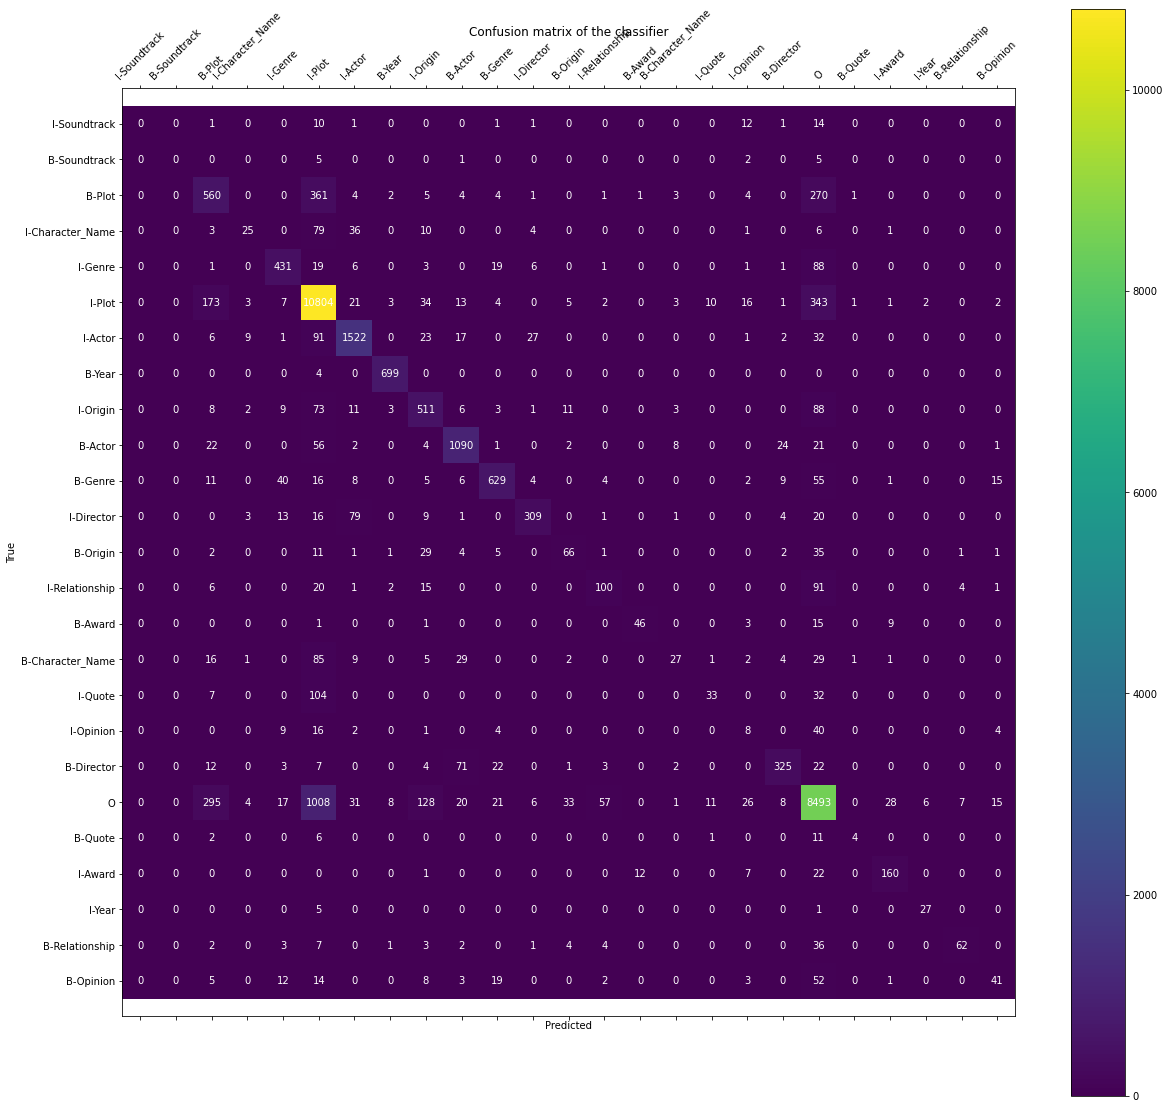

In [147]:
confusion_matrix_heatmap(ytest_data_q4, predictions)

In [148]:
print_most_predictive_state_features(ct_q4._tagger.info().state_features.items())

Streaming output truncated to the last 5000 lines.
0.015330 I-Plot   WORD_slavery
0.015330 I-Origin WORD_cleary
0.015318 B-Plot   SUF_lic
0.015309 I-Plot   WORD_psychopathic
0.015288 B-Plot   SUF_ea
0.015282 I-Plot   WORD_scenario
0.015272 I-Plot   WORD_boulders
0.015232 I-Plot   WORD_eight
0.015222 I-Plot   WORD_surprising
0.015203 I-Director SUF_ge
0.015151 I-Origin SUF_86
0.015151 I-Origin SUF_986
0.015151 I-Origin WORD_1986
0.015121 I-Plot   WORD_planets
0.015087 I-Plot   WORD_illness
0.015083 I-Plot   WORD_repairing
0.015060 I-Plot   WORD_prospector
0.015052 I-Plot   WORD_cassette
0.015035 I-Plot   WORD_goods
0.015032 I-Plot   WORD_navigate
0.015026 I-Plot   WORD_handicapped
0.014979 I-Plot   WORD_form
0.014977 I-Plot   WORD_2000
0.014973 I-Plot   WORD_otherworldly
0.014938 I-Plot   WORD_jailer
0.014937 I-Plot   WORD_lookout
0.014891 I-Plot   WORD_purchasing
0.014889 I-Origin WORD_mark
0.014887 I-Plot   WORD_generated
0.014880 I-Plot   WORD_spotting
0.014877 I-Plot   WORD_throats


## Conclusion:-

<h4><em>On printing the classification matrix I found out that the macro_avg went on to increase from 0.553 to 0.559 which is not significant but it can be said that adding some more features would definitely increase the macro_avg to greater extent. This also increases the precision and recall which inturn decreases the number of false positives and false negatives. For exmaple for the class I-Plot, I-Actor was misclassified as the I-Plot 136 times previously, but with the newly added features the false positives have decreased to just 91. Similarly many classes now have a reduced number of false positives and false negatives.</em></h4>

# 5. Question 5- Feature experimentation and other optimization for optimal macro average (30 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format and make sure you describe this in your report.

Feature tips: You could try more suffixes/prefixes of the current word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q2 and Q3 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes.

Model tips: After your feature engineering, for even better performance you could try optimizing the hyperparameters by adjusting the `training_opt` dictionary values, experimenting with changing the minimum document frequency, c1 and c2 regularization parameters for https://www.nltk.org/api/nltk.tag.crf.html#nltk.tag.crf.CRFTagger.__init__ e.g. changing the initialization to make the minimum feature frequency 2 (rather than the default 1) would be:

`ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":2})`

Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `trivia10k13train.bio.txt`) as your final piece of code.

## Step 1:-
 <h4><em> Adding additional features to our get_features function in order to improve the performance of our model. The model which was trained in the previous question had a macro-avg score of about 0.56. I aim to improve this score by tweaking the get features function and testing different types of features and hyperparameters and observing the change in macro-avg. These are the following features that I am using for testing. </h3></em>

*'is_first_capital'  'is_first_word'  'is_last_word'  'is_complete_capital'  'is_numeric'  'is_alphanumeric'  'prefix_1' 'prefix_2'  'prefix_3'  'prefix_4'  'prefix_5' 'prev_word':  'next_word':  'suffix_1'  'suffix_2'  'suffix_3'  'suffix_4'  'suffix_5'  'word_has_hyphen'  'word':  'pos':  'previous pos':  'next_pos':  'punctuation'*

In [149]:
def get_features_q5_1(sentence,index):
    # sentence is of the form [w1,w2,w3,..], index is the position of the word in the sentence
    word_pos = sentence[index]
    # as we added the pos tags to the words in our sentences, while extarcting the features we
    # need to separte them using the split funciton in order to consider them as separate features
    token = word_pos.split('+')
    

    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token[0]):
        return 'punctuation'
    

    return {
        'is_first_capital':int(token[0][0].isupper()),
        'is_complete_capital': int(token[0].upper()==token[0]),
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',token[0])))),
        'prefix_1':token[0][:-1] if len(token[0]) > 1 else 0,
        'prefix_2':token[0][:-2] if len(token[0]) > 2 else 0,
        'prefix_3':token[0][:-3] if len(token[0]) > 3 else 0,
        'prefix_4':token[0][:-4] if len(token[0]) > 4 else 0,
        'prefix_5':token[0][:-5] if len(token[0]) > 5 else 0,
        'suffix_1':token[0][-1:] if len(token[0]) > 1 else 0,
        'suffix_2':token[0][-2:] if len(token[0]) > 2 else 0,
        'suffix_3':token[0][-3:] if len(token[0]) > 3 else 0,
        'suffix_4':token[0][-4:] if len(token[0]) > 4 else 0,
        'suffix_5':token[0][-5:] if len(token[0]) > 5 else 0,
        'word': token[0],
        'pos': token[1],
        'punctuation':int(all(unicodedata.category(x) in punc_cat for x in token[0]))
        
        }

In [150]:
# adding new features to the get_features model to see improvement in the model
# checking if the word is the first or the last word in a sentence

def get_features_q5_2(sentence,index):
    # sentence is of the form [w1,w2,w3,..], index is the position of the word in the sentence
    word_pos = sentence[index]
    # as we added the pos tags to the words in our sentences, while extarcting the features we
    # need to separte them using the split funciton in order to consider them as separate features
    token = word_pos.split('+')
    

    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token[0]):
        return 'punctuation'
    

    return {
        'is_first_capital':int(token[0][0].isupper()),
        'is_first_word': int(index==0),
        'is_last_word':int(index==len(sentence)-1),
        'is_complete_capital': int(token[0].upper()==token[0]),
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',token[0])))),
        'prefix_1':token[0][:-1] if len(token[0]) > 1 else 0,
        'prefix_2':token[0][:-2] if len(token[0]) > 2 else 0,
        'prefix_3':token[0][:-3] if len(token[0]) > 3 else 0,
        'prefix_4':token[0][:-4] if len(token[0]) > 4 else 0,
        'prefix_5':token[0][:-5] if len(token[0]) > 5 else 0,
        'suffix_1':token[0][-1:] if len(token[0]) > 1 else 0,
        'suffix_2':token[0][-2:] if len(token[0]) > 2 else 0,
        'suffix_3':token[0][-3:] if len(token[0]) > 3 else 0,
        'suffix_4':token[0][-4:] if len(token[0]) > 4 else 0,
        'suffix_5':token[0][-5:] if len(token[0]) > 5 else 0,
        'word': token[0],
        'pos': token[1],
        'punctuation':int(all(unicodedata.category(x) in punc_cat for x in token[0]))
        
        }

In [151]:
#removing the features prefix 1,2 and suffix 1,2 to see a change 

def get_features_q5_3(sentence,index):
    # sentence is of the form [w1,w2,w3,..], index is the position of the word in the sentence
    word_pos = sentence[index]
    # as we added the pos tags to the words in our sentences, while extarcting the features we
    # need to separte them using the split funciton in order to consider them as separate features
    token = word_pos.split('+')
    

    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token[0]):
        return 'punctuation'
    

    return {
        'is_first_capital':int(token[0][0].isupper()),
        'is_first_word': int(index==0),
        'is_last_word':int(index==len(sentence)-1),
        'is_complete_capital': int(token[0].upper()==token[0]),
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',token[0])))),

        'prefix_3':token[0][:-3] if len(token[0]) > 3 else 0,
        'prefix_4':token[0][:-4] if len(token[0]) > 4 else 0,
        'prefix_5':token[0][:-5] if len(token[0]) > 5 else 0,
        'prev_word':'' if index==0 else sentence[index-1].split('+')[0],
        'next_word':'' if index==len(sentence)-1 else sentence[index+1].split('+')[0],

        'suffix_3':token[0][-3:] if len(token[0]) > 3 else 0,
        'suffix_4':token[0][-4:] if len(token[0]) > 4 else 0,
        'suffix_5':token[0][-5:] if len(token[0]) > 5 else 0,
        'word_has_hyphen': 1 if '-' in token[0] else 0,
        'word': token[0],
        'pos': token[1],
        'punctuation':int(all(unicodedata.category(x) in punc_cat for x in token[0]))
        
        }

In [152]:
# adding previous and next pos of the word to the feature set 

def get_features_q5(sentence,index):
    # sentence is of the form [w1,w2,w3,..], index is the position of the word in the sentence
    word_pos = sentence[index]
    # as we added the pos tags to the words in our sentences, while extarcting the features we
    # need to separte them using the split funciton in order to consider them as separate features
    token = word_pos.split('+')
    

    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token[0]):
        return 'punctuation'
    

    return {
        'is_first_capital':int(token[0][0].isupper()),
        'is_first_word': int(index==0),
        'is_last_word':int(index==len(sentence)-1),
        'is_complete_capital': int(token[0].upper()==token[0]),
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',token[0])))),

        'prefix_3':token[0][:-3] if len(token[0]) > 3 else 0,
        'prefix_4':token[0][:-4] if len(token[0]) > 4 else 0,
        'prefix_5':token[0][:-5] if len(token[0]) > 5 else 0,
        'prev_word':'' if index==0 else sentence[index-1].split('+')[0],
        'next_word':'' if index==len(sentence)-1 else sentence[index+1].split('+')[0],

        'suffix_3':token[0][-3:] if len(token[0]) > 3 else 0,
        'suffix_4':token[0][-4:] if len(token[0]) > 4 else 0,
        'suffix_5':token[0][-5:] if len(token[0]) > 5 else 0,
        'word_has_hyphen': 1 if '-' in token[0] else 0,
        'word': token[0],
        'pos': token[1],
        'previous pos': '' if index==0 else sentence[index-1].split('+')[1],
        'next_pos':'' if index==len(sentence)-1 else sentence[index+1].split('+')[1],
        'punctuation':int(all(unicodedata.category(x) in punc_cat for x in token[0]))
        
        }

## Step 2:- 
<h4><em>Trying and testing new features (4 different functions/feature sets) on the 80:20 split developement dataset. Here I use the same data which was used in the question 4 which contained the (Word+POS) format. To further improve the performance of the model I have added 4 hyperparameters while training. I first set the max_iterations as '100' which shall prevent the model from excessive training and avoid overfitting. Moreover I set the min frequency of features as '2', c1=0.25 (the coefficient for L1 regularization) c2=0.3 (the coefficient for L1 regularization).Using the trained model, I make predictions on our 20% developement test data. </h3></em>


### 2.1 
<h4><em>Testing the model performance with our first set of features</em></h4>

In [153]:
# prepare the test data:
test_data_q5_1 = test_data_q4
print(len(test_data_q5_1), "instances")
print(sum([len(sent) for sent in test_data_q5_1]), "words")

train_data_q5_1 = train_data_q4
print(len(train_data_q5_1), "train instances")
print(sum([len(sent) for sent in train_data_q5_1]), "train words")

# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger_q5_1"  
ct_5_1 = CRFTagger(feature_func=get_features_q5_1)
print("training tagger...")
ct_5_1.train(train_data_q5_1, TAGGER_PATH)
print("done")


# load tagger from saved file
#ct_5 = CRFTagger(feature_func=get_features_2)  # initialize tagger
ct_5_1.set_model_file(TAGGER_PATH)  # load model from file

print("testing tagger on test data...")
preds_5_1 = []
y_test_5_1 = []
for sent in test_data_q5_1:
    sent_preds = [x[1] for x in ct_5_1.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_5_1.extend(sent_preds)
    y_test_5_1.extend(sent_true)
print("done")
print(classification_report(y_test_5_1, preds_5_1))
print(precision_recall_fscore_support(y_test_5_1, preds_5_1, average='macro'))

1564 instances
31304 words
6252 train instances
127519 train words
training tagger...
done
testing tagger on test data...
done
                  precision    recall  f1-score   support

         B-Actor       0.88      0.91      0.89      1231
         B-Award       0.78      0.68      0.73        75
B-Character_Name       0.66      0.27      0.38       212
      B-Director       0.86      0.74      0.79       472
         B-Genre       0.88      0.84      0.86       805
       B-Opinion       0.60      0.36      0.45       160
        B-Origin       0.55      0.46      0.50       159
          B-Plot       0.48      0.45      0.47      1221
         B-Quote       0.86      0.25      0.39        24
  B-Relationship       0.81      0.52      0.63       125
    B-Soundtrack       0.33      0.08      0.12        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.90      0.91      0.91      1731
         I-Award       0.87      0.82      0.84       202
I-

<h4><em>Taking into consideration five prefixes and five suffixes has increased our macro-average from 0.559 to 0.61 which is a good amount of increment </em></h4>

### 2.2 
<h4><em>Testing our model performance with the second set of features</em><h4>

In [154]:
# prepare the test data:
test_data_q5_1 = test_data_q4
print(len(test_data_q5_1), "instances")
print(sum([len(sent) for sent in test_data_q5_1]), "words")

train_data_q5_1 = train_data_q4
print(len(train_data_q5_1), "train instances")
print(sum([len(sent) for sent in train_data_q5_1]), "train words")

# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger_q5_1"  
ct_5_1 = CRFTagger(feature_func=get_features_q5_2)
print("training tagger...")
ct_5_1.train(train_data_q5_1, TAGGER_PATH)
print("done")


# load tagger from saved file
#ct_5 = CRFTagger(feature_func=get_features_2)  # initialize tagger
ct_5_1.set_model_file(TAGGER_PATH)  # load model from file

print("testing tagger on test data...")
preds_5_1 = []
y_test_5_1 = []
for sent in test_data_q5_1:
    sent_preds = [x[1] for x in ct_5_1.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_5_1.extend(sent_preds)
    y_test_5_1.extend(sent_true)
print("done")
print(classification_report(y_test_5_1, preds_5_1))
print(precision_recall_fscore_support(y_test_5_1, preds_5_1, average='macro'))

1564 instances
31304 words
6252 train instances
127519 train words
training tagger...
done
testing tagger on test data...
done
                  precision    recall  f1-score   support

         B-Actor       0.89      0.91      0.90      1231
         B-Award       0.79      0.69      0.74        75
B-Character_Name       0.70      0.26      0.38       212
      B-Director       0.88      0.74      0.80       472
         B-Genre       0.88      0.83      0.85       805
       B-Opinion       0.59      0.36      0.45       160
        B-Origin       0.55      0.45      0.49       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.86      0.25      0.39        24
  B-Relationship       0.84      0.53      0.65       125
    B-Soundtrack       0.50      0.15      0.24        13
          B-Year       0.98      0.98      0.98       703
         I-Actor       0.90      0.92      0.91      1731
         I-Award       0.87      0.77      0.82       202
I-

<h4><em>Inspite of adding two new features that are "if the word is the first word or the last word of the sentence", our macro-average has not increased a lot. I decided to remove the features prefix/suffix 1 and 2 in the next feature set and see a change</em></h4>

### 2.3
<h4><em>Testing the model performance with 3rd set of features</em></h4>

In [155]:
# prepare the test data:
test_data_q5_1 = test_data_q4
print(len(test_data_q5_1), "instances")
print(sum([len(sent) for sent in test_data_q5_1]), "words")

train_data_q5_1 = train_data_q4
print(len(train_data_q5_1), "train instances")
print(sum([len(sent) for sent in train_data_q5_1]), "train words")

# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger_q5_1"  
ct_5_1 = CRFTagger(feature_func=get_features_q5_3)
print("training tagger...")
ct_5_1.train(train_data_q5_1, TAGGER_PATH)
print("done")


# load tagger from saved file
#ct_5 = CRFTagger(feature_func=get_features_2)  # initialize tagger
ct_5_1.set_model_file(TAGGER_PATH)  # load model from file

print("testing tagger on test data...")
preds_5_1 = []
y_test_5_1 = []
for sent in test_data_q5_1:
    sent_preds = [x[1] for x in ct_5_1.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_5_1.extend(sent_preds)
    y_test_5_1.extend(sent_true)
print("done")
print(classification_report(y_test_5_1, preds_5_1))
print(precision_recall_fscore_support(y_test_5_1, preds_5_1, average='macro'))

1564 instances
31304 words
6252 train instances
127519 train words
training tagger...
done
testing tagger on test data...
done
                  precision    recall  f1-score   support

         B-Actor       0.93      0.93      0.93      1231
         B-Award       0.80      0.69      0.74        75
B-Character_Name       0.82      0.36      0.50       212
      B-Director       0.90      0.78      0.84       472
         B-Genre       0.88      0.83      0.86       805
       B-Opinion       0.60      0.36      0.45       160
        B-Origin       0.59      0.50      0.54       159
          B-Plot       0.49      0.45      0.47      1221
         B-Quote       0.86      0.25      0.39        24
  B-Relationship       0.80      0.55      0.65       125
    B-Soundtrack       0.67      0.15      0.25        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.93      0.94      0.93      1731
         I-Award       0.82      0.77      0.79       202
I-

<h4><em>It is evident that removing the 1,2 suffix and prefix has increased the model performance by a fair amount. The macro average has now increased from 0.61 to 0.638.</em></h4>

### 2.4
<h4><em>Testing our model on the final feature set where we add the next and previous pos tags of the words along and with added hyper parameters. </h4></em>

In [156]:


# prepare the test data:
test_data_q5_1 = test_data_q4
print(len(test_data_q5_1), "instances")
print(sum([len(sent) for sent in test_data_q5_1]), "words")

train_data_q5_1 = train_data_q4
print(len(train_data_q5_1), "train instances")
print(sum([len(sent) for sent in train_data_q5_1]), "train words")

# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger_q5_1"  
ct_5_1 = CRFTagger(feature_func=get_features_q5, training_opt = {
    'max_iterations':100,
    'c1':0.1,
    'c2':0.1,
    'feature.possible_transitions':False}) 

print("training tagger...")
ct_5_1.train(train_data_q5_1, TAGGER_PATH)
print("done")




# load tagger from saved file
#ct_5 = CRFTagger(feature_func=get_features_2)  # initialize tagger
ct_5_1.set_model_file(TAGGER_PATH)  # load model from file

print("testing tagger on test data...")
preds_5_1 = []
y_test_5_1 = []
for sent in test_data_q5_1:
    sent_preds = [x[1] for x in ct_5_1.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_5_1.extend(sent_preds)
    y_test_5_1.extend(sent_true)
print("done")
print(classification_report(y_test_5_1, preds_5_1))
print(precision_recall_fscore_support(y_test_5_1, preds_5_1, average='macro'))

1564 instances
31304 words
6252 train instances
127519 train words
training tagger...
done
testing tagger on test data...
done
                  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.93      1231
         B-Award       0.74      0.67      0.70        75
B-Character_Name       0.75      0.41      0.53       212
      B-Director       0.90      0.78      0.84       472
         B-Genre       0.88      0.83      0.86       805
       B-Opinion       0.58      0.37      0.45       160
        B-Origin       0.57      0.48      0.53       159
          B-Plot       0.46      0.43      0.45      1221
         B-Quote       0.75      0.25      0.38        24
  B-Relationship       0.73      0.54      0.62       125
    B-Soundtrack       0.75      0.23      0.35        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.93      0.94      0.94      1731
         I-Award       0.84      0.71      0.77       202
I-

<h4><em> The valule of our macro avg has further inceased to 0.642 by adding the hyperparameters c1,c2 and setting the maximum iterations as 100. Now we need to further tune the value of c1 and c2 to get even better results.

### 2.5
 <h4><em>Changing the value of c1,c2 and adding the minimun frequency for features as 2</em></h4>

In [157]:


# prepare the test data:
test_data_q5_1 = test_data_q4
print(len(test_data_q5_1), "instances")
print(sum([len(sent) for sent in test_data_q5_1]), "words")

train_data_q5_1 = train_data_q4
print(len(train_data_q5_1), "train instances")
print(sum([len(sent) for sent in train_data_q5_1]), "train words")

# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger_q5_1"  
ct_5_1 = CRFTagger(feature_func=get_features_q5, training_opt = {
    'max_iterations':100,
    'feature.minfreq':2,
    'c1':0.25,
    'c2':0.3,
    'feature.possible_transitions':False}) 

print("training tagger...")
ct_5_1.train(train_data_q5_1, TAGGER_PATH)
print("done")




# load tagger from saved file
#ct_5 = CRFTagger(feature_func=get_features_2)  # initialize tagger
ct_5_1.set_model_file(TAGGER_PATH)  # load model from file

print("testing tagger on test data...")
preds_5_1 = []
y_test_5_1 = []
for sent in test_data_q5_1:
    sent_preds = [x[1] for x in ct_5_1.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_5_1.extend(sent_preds)
    y_test_5_1.extend(sent_true)
print("done")

1564 instances
31304 words
6252 train instances
127519 train words
training tagger...
done
testing tagger on test data...
done


## Step 3:-
<h4><em> As I have just trained our final model and also made predictions with the newly extracted features, prinitng the classification report to notice a change in the performance of our model.</em></h4>

In [158]:
print(classification_report(y_test_5_1, preds_5_1))
print(precision_recall_fscore_support(y_test_5_1, preds_5_1, average='macro'))

                  precision    recall  f1-score   support

         B-Actor       0.93      0.93      0.93      1231
         B-Award       0.72      0.63      0.67        75
B-Character_Name       0.78      0.39      0.52       212
      B-Director       0.90      0.79      0.84       472
         B-Genre       0.87      0.82      0.85       805
       B-Opinion       0.59      0.36      0.45       160
        B-Origin       0.63      0.53      0.57       159
          B-Plot       0.49      0.45      0.47      1221
         B-Quote       0.78      0.29      0.42        24
  B-Relationship       0.77      0.54      0.64       125
    B-Soundtrack       0.67      0.31      0.42        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.94      0.94      0.94      1731
         I-Award       0.79      0.74      0.76       202
I-Character_Name       0.80      0.41      0.54       165
      I-Director       0.92      0.79      0.85       456
         I-Ge

<h4><em>It can be seen that adding the hyperparameters and the new pos features, our model's macro avg(f1 score) has increased form 0.64 to 0.65. By iteratively trying different feature sets and hyper-parameters we have increased the macro-avg f1 score of our model from 0.559 to 0.651 which is a signification amount of increment. </em></h4>

## Conclusion:- 
<h4><em>It can be said that the final feature set has the optimal set of features because it has the best macro-avg out of all the models trained on different feature sets. From having a look at the classification report, I cam say that increasing the quality and number of features and also the hyperparameters, has improved the performance of our model. The macro-avg which was just 0.559 for the initial model, has now increased to 0.651 which is a significant improvement. Further some of the classes have shown significant improvements in their individual performance for example the macro-avg(f1-score) for B-Soundtrack has increased from 0 to 0.42. Other classes that has shown improvements are:- </em><h4>

**macroavg (f1 score)**
*   B-Actor 0.87 --> 0.93
*   B-Director 0.76 --> 0.84
*   B-Quote 0.26 --> 0.42
*   B-Soundtrack 0.00 --> 0.42
*   I-Director 0.76 --> 0.85
*   B-Opinion 0.34 --> 0.45
*   I-Opinion 0.09 --> 0.23
*   B-Origin 0.47 --> 0.57
*   B-Character_Name 0.21 --> 0.52
*   I-Soundtrack 0.00 --> 0.31
*   I-Quote 0.28 --> 0.36








## <h1>Training on the original data</h1>
 <h1><em>After training, testing and extracting the best features and hyperparameters, now using those features training and testing the model the original full test-train datasets.</em></h1>


<h4><em> In order to improve the macro average f-score we need to add more relevant features which will enable the model to make better predictions. As we added the POS tags to the words in the training data in the previous question,  we observed an increase in the macro_avg. Therefore the final features used to train our model are :-<em></h4>


[ 'is_first_capital' , 'is_first_word' , 'is_last_word' , 'is_complete_capital' ,'is_numeric' , 'is_alphanumeric' , 'prefix_3' , 'prefix_4' , 'prefix_5' ,    'prev_word' , 'next_word' , 'suffix_3' , 'suffix_4' , 'suffix_5' ,'word_has_hyphen' , 'word' , 'pos' , 'previous pos' , 'next_pos']


## Step 1:-
<h4><em>The original data is in the format of [('word','crf tag')], so I create a function to pre-process the raw data (similar to that in question 4) into the format where we added the POS tag with the word. </em></h4>






In [159]:
def preProcess_q5(X_train):
  
    comb_list = []
    for sen in X_train:
      crf = [s[1] for s in sen]
      word = [s[0] for s in sen]
      pos_tags = posttagger.tag(word)
      words_plus_tags = []
      for elem in pos_tags:
        wpt = elem[0]+'+'+ elem[1]
        words_plus_tags.append(wpt)
      comb_list.append(words_plus_tags)

    X_train = list(X_train)
    for i in range(len(X_train)):
      for j in range(len(X_train[i])):
        X_train[i][j] = list(X_train[i][j])
    
    for i in range(len(X_train)):
      for j in range(len(X_train[i])):
        X_train[i][j][0] = comb_list[i][j]

    new_train_data = X_train
    return new_train_data

## Step 2:-      
<h4><em> Preprocessing our raw data using the preProcess_q5 function that we created above this cell. After we have pre-processed the data, we train our model using the final features that we tried and tested on our 80:20 split data. Further we make predictions using the trained model and store the labels into different lists for evaluation purposes.

In [160]:
# Final results on original test data, using all training data, with best settings from dev set:

# reading our original test data and pre-
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data_q5 = preProcess_q5(raw_test_data)
print(len(test_data_q5), "test instances")
print(sum([len(sent) for sent in test_data_q5]), "test words")

raw_train_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 
train_data_q5 = preProcess_q5(raw_train_data)
print(len(train_data_q5), "train instances")
print(sum([len(sent) for sent in train_data_q5]), "train words")

# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger_q5"  # path to the tagger- it will save/access the model from here
ct_5 = CRFTagger(feature_func=get_features_q5, training_opt = {
    'max_iterations':100,
    'feature.minfreq':2,
    'c1':0.25,
    'c2':0.3,
    'feature.possible_transitions':False})  # initialize tagger with get_features function

print("training tagger...")
ct_5.train(train_data_q5, TAGGER_PATH)
print("done")




# load tagger from saved file
#ct_5 = CRFTagger(feature_func=get_features_2)  # initialize tagger
ct_5.set_model_file(TAGGER_PATH)  # load model from file

print("testing tagger on test data...")
preds_5 = []
y_test_5 = []
for sent in test_data_q5:
    sent_preds = [x[1] for x in ct_5.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds_5.extend(sent_preds)
    y_test_5.extend(sent_true)
print("done")

1953 test instances
39035 test words
7816 train instances
158823 train words
training tagger...
done
testing tagger on test data...
done


## Step 3:-    
<h4><em>Finally we generate our classification report to see if the performanece of our model has improved or not</em></h4>

In [161]:
print(classification_report(y_test_5, preds_5))
print(precision_recall_fscore_support(y_test_5, preds_5, average='macro'))

                  precision    recall  f1-score   support

         B-Actor       0.93      0.92      0.93      1274
         B-Award       0.70      0.70      0.70        66
B-Character_Name       0.75      0.47      0.58       283
      B-Director       0.85      0.86      0.86       425
         B-Genre       0.83      0.79      0.81       789
       B-Opinion       0.46      0.42      0.44       195
        B-Origin       0.48      0.39      0.43       190
          B-Plot       0.51      0.49      0.50      1577
         B-Quote       0.80      0.34      0.48        47
  B-Relationship       0.84      0.57      0.68       171
    B-Soundtrack       1.00      0.25      0.40         8
          B-Year       0.97      0.97      0.97       661
         I-Actor       0.92      0.93      0.92      1553
         I-Award       0.78      0.80      0.79       147
I-Character_Name       0.72      0.55      0.62       227
      I-Director       0.90      0.87      0.88       411
         I-Ge

## Conclusion:-

<h4><em>The final macro average of the f1 score that we have obtained is 0.662 which I think is a substantial increment from the macro average that we obatained when we used minimal features in question 4. Similar to the results obatined in the previous section where we trained and tested on the 80:20 split data, I saw an incresae in performance of individual classes. 

**macroavg (f1 score)**
*   B-Actor 0.87 --> 0.93
*   B-Director 0.78 --> 0.86
*   B-Quote 0.38 --> 0.48
*   B-Soundtrack 0.00 --> 0.4
*   I-Director 0.81 --> 0.88
*   B-Opinion 0.37 --> 0.44
*   I-Opinion 0.10 --> 0.24
*   B-Origin 0.47 --> 0.57
*   B-Character_Name 0.37 --> 0.58
*   I-Soundtrack 0.00 --> 0.32
*   I-Quote 0.63 --> 0.71

</em></h4>

<h4><em> On printing the most predictive features for this model, it can be seen that the added features pos, previous-pos,next-pos, next-word, previous word, the 4/5 prefix/suffix contribute a lot to the model.
On improving the macro-avg(f1-score) our model we also have reduced the number of errors i.e the false positives and the false negatives. This can be quanified by looking at the individual performance of the classes which is shown above </em></h4>